### Come back to [Introduction](Introduction.ipynb)
<a id="0" />

# Part II: Network analysis
> In this section, we will perform a network analysis regarding the Amazon's UK customers review. The main purpose of this analysis is to find out interesting relationship between products and customers. Particularly, we are interested in discovering connection between a user and a product as well as customers/products pair. In order to thorough analyse the dataset, we will build three different networks:
* [Bipartite Customers-Products network](#Customers-Products)
* [Customers network](#Customers)
* [Products network](#Products)

> Due to huge size of the dataset, we will study the whole network only when it will be possible. Otherwise, we will focus in a subgraph. 
## Prerequisites 
> In this section, we import all the libraries used during the development of the notebook. Additionally, we define the path which indicates where the pickle files are stored. Finally, we read all the pickle file needed for the following analysis.
### Libraries

In [50]:
import re
from os import listdir
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import matplotlib.pylab as plt
from matplotlib import rcParams
import community
from fa2 import ForceAtlas2

### File's path  

In [2]:
# Path where all useful files are stored.
PATH_DATA = "../../Files/"

### Pickle files
> We used the pickle package in order to store several structures which, due to the huge size of the network, requires a significant amount of time to be computed. By doing this, we were able to compute these structure only once and save valuable time in the following iterations.

> Below, we load a dataframe containing all the review's information needed to build the networks. 

In [3]:
# Loading the dataframe by the related pickle file.
df_no_text = pd.read_pickle("%sAmazonDataProjectNoText.pkl" % PATH_DATA)

<a id = "Functions">

### Usefull functions
> In this section, we define several functions which will be used multiple times in the following sections.

In [4]:
# This function receives as input a graph and prints its number of nodes and edges.
def printNodesEdges(g):
    print("The number of nodes is: %d" %(len(g.nodes())))
    print("The number of edges is: %d" %(len(g.edges())))

In [5]:
# This function receives as input a graph and plot its degree distribution.
def plotDegree(g, log = True, line = False):
    degrees = list()
    for i in g:
        degrees.append(g.degree(i))
    print("Maximum degree = " + str(max(degrees)))
    print("Minimum degree = " + str(min(degrees)))
    v, b = np.histogram(degrees, max(degrees))
    v = np.append(v, 0)
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.rcParams.update({'font.size': 15})
    plt.title('Degree distribution linear')
    plt.xlabel('k')
    plt.ylabel('Count')
    if line:
        plt.plot(b, v, 'b.:', markersize = 3)
    else:
        plt.plot(b, v, 'b.', markersize = 3)
    plt.show()
    if(log):
        plt.title('Degree distribution log')
        plt.xlabel('k')
        plt.ylabel('Count')
        plt.xscale('log')
        plt.yscale('log')
        plt.plot(b, v, 'bo', markersize = 3)
        plt.show()

In [6]:
# This function as input a graph and returns the number of time the Friendship paradox is respected
def friendship(g):
    isTrue = 0
    for node in g.nodes():
        if nx.average_neighbor_degree(g, nodes = [node])[node] > g.degree(node):
            isTrue += 1
    return isTrue

In [7]:
# This function receives as input the name of the network, the graph's lenght and the friendship's result, subsequently, it prints the result.
def printFriendship(name, lenght, succ):
    print("In the %s network, the friendship paradox was true for %d times out of %d, %.2f per cent." %(name, succ, lenght, float(100 * succ / lenght)))

In [8]:
# This function receives as input a graph and if connected, it prints the average shortest path
def shortestPath(g):
    try:
        print("The average shortest path is: %f" %(nx.average_shortest_path_length(g)))
    except:
        print("The network is not connected")

In [9]:
# This function receives as input a graph a computes its assortativity.
def assortativity(g):
    print("The assortativity coeffcient is: %f" %(nx.degree_assortativity_coefficient(g, weight = "weight")))

In [10]:
# This function receives as input a graph and computes the average degree connectivity. Then, it print the distribution
def averageDegreeCon(g, nbin):
    avgd = nx.average_degree_connectivity(g)
    xavgd = []
    for p in avgd:
        xavgd.append(avgd[p])
    plt.rcParams["figure.figsize"] = [15, 8]
    plt.hist(xavgd, nbin)
    plt.title('Average degree connectivity distribution')
    plt.xlabel('Average degree')
    plt.ylabel('Count')
    plt.show()

<a id = "Customers-Products">

## Customers-Products network
> **Interests:** In this section, we are interested in building a bipartite Customers-Products network representing the relationships between customers and products. Then, we will analyse this network in order to discover interensting properties among products and users. This network is built as follow:
* Nodes: There are two types of nodes: customers and products. Each node has ***isCust*** property which indicates if the node represents a customer or a product. Meanwhile, product nodes have two additional properties: ***title*** and ***cat***, they represent the product's title and category respectively.
* Edges: Each edge connects a customer to a product, it represents the review made by the customer about that product. Customer's nodes can be linked only with the product's nodes and vice versa. That is why it is a bipartite network. Furthermore, each edge stores four properties:
 * ***weight***: It represents the star rate given by the customer
 * ***date***: It represents the review's date
 * ***id_rew***: It represents the review's id

> **Tool:** To create the Customers-Products network, we use the *NetworkX* package. This package is very useful to represent and analyse networks. Additionally, we use the *Pickle* library which allows us to save our data into a file. This operation remarkably speeds up the future computations. 

> **Application of the tool:** In order to build the network described above, we scan all the reviews contained in the dataframe. For each of them, we create the associated edge within the related properties. Subsequently, we save this network in a pickle file. Through this file, next time we need to compute the network, it will be remarkably faster.
#### Building network

In [115]:
# Ceating graph
gCP = nx.Graph()

In [117]:
# Populating graph
for index, row in df_no_text.iterrows():
    gCP.add_node(row.customer_id, isCust = True)
    gCP.add_node(row.product_id, isCust = False, title = row.product_title, cat = row.product_category)
    gCP.add_edge(row.customer_id, row.product_id, weight = row.star_rating, date = row.review_date, id_rew = index)

> Writing pickle file storing the network.

In [118]:
#Writing pickle file containing the network
nx.write_gpickle(gCP, "%srawNetwork.gpickle" %PATH_DATA)

> Loading the network from pickle file.

In [119]:
#Loading the network stored in the related pickle file
gCP = nx.read_gpickle("%srawNetwork.gpickle" %PATH_DATA)

> **Outcomes:** At the end of this process, the bipartite Customers-Products network has been created and the associate pickle file has been saved. Thanks to this file, the following times we will need to compute the network we will be able to obtain it significantly faster.
### Customers-Products basic stats 
> **Interests:** Here, we start to study the Customers-Products network. As a first analysis, we focus on the size of the network by looking at its number of nodes and edges. Secondly, we plot the degree distribution using both a linear and log scale. By doing this, we want to understand the network's size as well as if its degree distribution reflects some relevant properties.

> **Tool:** To do what is described above, we use some *NetworkX*'s functions which allow to easily compute the number of nodes and edges. Subsequently, we plot the degree distribution by means of the *Matplotlib.hist* function which given some bins and values, it plots the corresponded histogram. To do this, we also use the *Numpy.histogram* function which given a list of values and a number of bins, it returns the corresponded bins within the related number of elements contained in each bin.

> **Application of the tool** To apply these tools, we developed two functions which can be seen [here](#Functions). In the first one, we simply called the *NetworkX.nodes* and *NetworkX.edges* functions on the Customers-Products network. Meanwhile, in the second one, we first created a list containing the node's degrees. Secondly, we used the *Numpy.histogram* to create the bin-#elements pairs. For each degree, a bin containing the number of nodes with that degree is created. Lastly, we plotted the degree distribution using the *Matplotlib.hist* function.
#### Number of nodes and edges

In [123]:
# Printing number of nodes and edges
printNodesEdges(gCP)

The number of nodes is: 992122
The number of edges is: 1701243


#### Degree distribution

Maximum degree = 7723
Minimum degree = 1


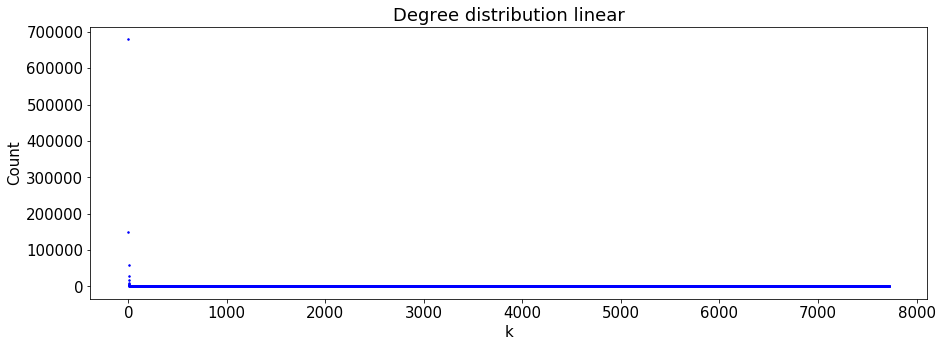

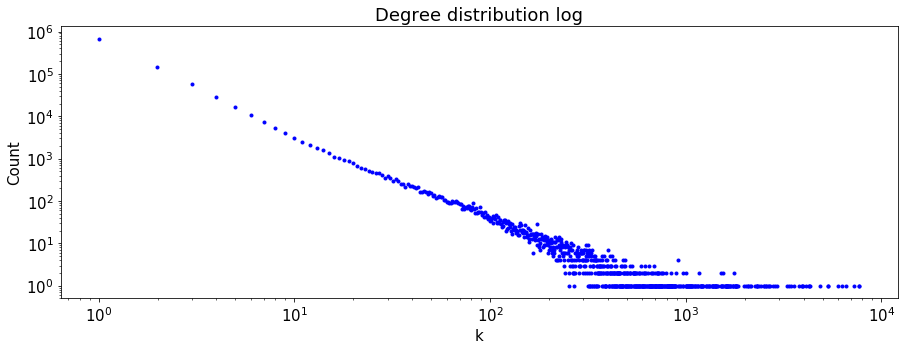

In [177]:
# Printing maimum and minimum degree and plotting degree distribution
plotDegree(gCP)

> **Outcomes:** The results suggest that the network is quite huge. Indeed, it is composed by ***992122*** nodes within ***1701243*** edges. Meanwhile, The degree analysis shows that there is a big gap between the minimum and maximum degree. However, it also shows that the majority of the nodes have a small degree, whereas, the higher degrees are spread among few nodes. This suggests that probably there are many customers which have reviewed a small number of products and vice versa, many products which have been reviewed by few customers. Simultaneously, it suggests that there few nodes which have an elevated degree. Since it is reasonably infeasible that a single customer has reviewed so many products, we believe that these nodes correspond to the top-sold items. 
### Friendship paradox
> **Interestes:** Looking at the degree distribution, it seems to follow a power law distribution. Consequently, we suppose that the Customers-Product network represents a *Scale-Free network*. This fostered us to study if the *Friendship paradox* is respected by the network. 

> **Tool:** The *Friendship paradox* states that give a randomly taken node, it is more likely that it has fewer neighbours that its neighbours. In order to evaluate how much the network respects the *Friendship paradox*, we use the *NetworkX.average_neighbor_degree* function. This function receives as input a graph and returns the average degree between its neighbours. 

> **Application of the tool:** To calculate how many times the Customers-Products network satisfies the *Friendship paradox*, we developed a function, [click here to see it](#Functions), which scans all nodes and for each of them check if the *Friendship paradox* is respected or not. Ultimately, it returns the number of successes.

In [184]:
# Computing Friendship paradox
nSuccCP = friendship(gCP)

In [189]:
# Printing Friendship paradox result
printFriendship("Customers-Products", len(gCP), nSuccCP)

In the Customers-Products network, the friendship paradox was true for 951013 times out of 992122, 95.00 per cent.


> **Outcomes:** As can be seen above, the network totally satisfies the Friedship paradox. 
### Top category analysis
> **Interests:** Due to the huge size of the original network, we want to study a subgraph in order to understand if it reflects the same properties of the whole one. In particular, we first find the 10 biggest categories. Then, we will focus on the biggest one and we will analyse it. As we did in the previous network, we are interested in study its size, degree distribution and if it exhibits the *Friendship paradox*

> **Tool:** Here, we use approximately the same tools used in the [previous section](#Customers-Products).

> **Application of the tool:** To create the best-category network, we take all the review associato to that category and we create the network as we did in the previous one. Successively, to study the network's properties, we follow the same procedure used [above](#Customers-Products). 

<a id = "PreTopCategory">

In [140]:
# Finding the top 10 categories.
df_no_text.groupby("product_category").size().sort_values(ascending = False)[:10]

product_category
Video DVD                 463178
Music                     329854
Digital_Ebook_Purchase    289111
Books                     257793
Mobile_Apps               218031
Digital_Video_Download     31420
Digital_Music_Purchase     29263
Toys                       24493
PC                         16258
Camera                      6427
dtype: int64

> The category with more reviews is Video DVD which has 463178 reviews. Therefore, now we build the subgraph based on this category.
#### Building network

In [141]:
# Building the subgraph composed by the top category with more reviews.
gCPTop = nx.Graph()
count = 1
for re in df_no_text[df_no_text.product_category == "Video DVD"].index:
    if count % 10000 == 0:
        print("%d/463178" %(count))
    count += 1
    gCPTop.add_node(df_no_text.loc[re].product_id, isCust = False)
    gCPTop.add_node(df_no_text.loc[re].customer_id, isCust = True)
    gCPTop.add_edge(df_no_text.loc[re].product_id, df_no_text.loc[re].customer_id)

10000/463178
20000/463178
30000/463178
40000/463178
50000/463178
60000/463178
70000/463178
80000/463178
90000/463178
100000/463178
110000/463178
120000/463178
130000/463178
140000/463178
150000/463178
160000/463178
170000/463178
180000/463178
190000/463178
200000/463178
210000/463178
220000/463178
230000/463178
240000/463178
250000/463178
260000/463178
270000/463178
280000/463178
290000/463178
300000/463178
310000/463178
320000/463178
330000/463178
340000/463178
350000/463178
360000/463178
370000/463178
380000/463178
390000/463178
400000/463178
410000/463178
420000/463178
430000/463178
440000/463178
450000/463178
460000/463178


In [142]:
#Writing pickle file containing the network
nx.write_gpickle(gCPTop, "%stopCategoryNetwork.gpickle" %PATH_DATA)

In [143]:
#Loading the network stored in the related pickle file
gCPTop = nx.read_gpickle("%stopCategoryNetwork.gpickle" %PATH_DATA)

#### Number of nodes and edges

In [144]:
# Printing the number of nodes and edges
printNodesEdges(gCPTop)

The number of nodes is: 264632
The number of edges is: 462866


#### Degree distribution

Maximum degree = 3783
Minimum degree = 1


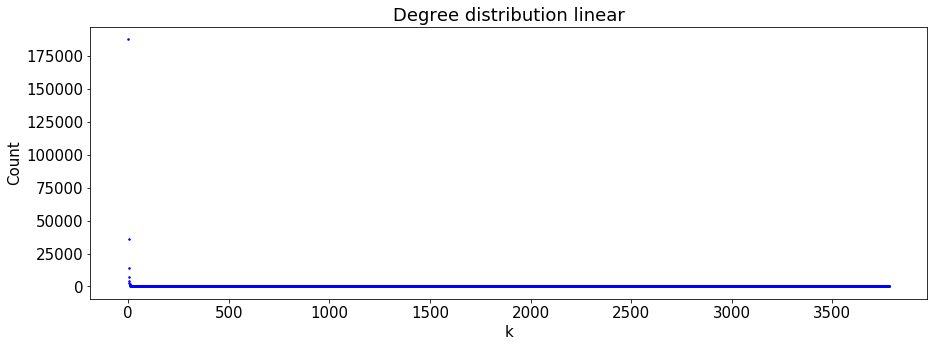

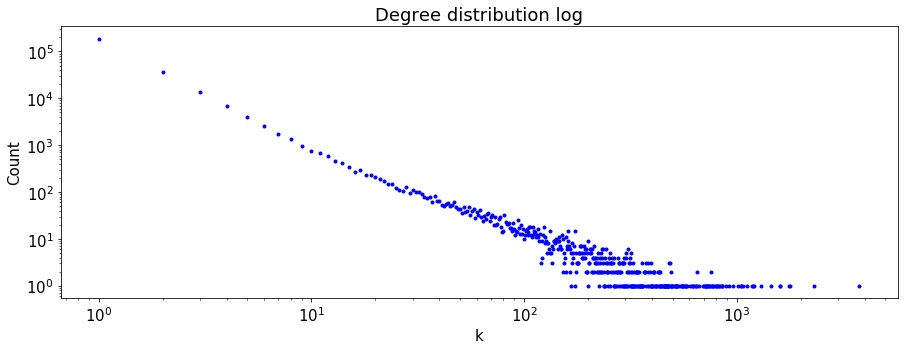

In [178]:
# Printing the maximum and minimum degree and plotting the degree distribution
plotDegree(gCPTop)

#### Friendship paradox

In [191]:
# Computing the Friendship paradox
nSuccCPTop = friendship(gCPTop)

In [192]:
# Printing the Friendship paradox result
printFriendship("Customers-Products top category", len(gCPTop), nSuccCPTop)

In the Customers-Products top category network, the friendship paradox was true for 255480 times out of 264632, 96.00 per cent.


<a id = "Subnetwork">

> **Outcomes:** Looking at the top 10 categories, it can be observed that all the best ones regard digital entertainment. In fact, the top 5 ones are Video DVD, Music, Digital_Ebook_Purchase, Books and Mobile_Apps. This result suggests that customers remarkably spend more time on entertainment content. Turning into the Video DVD subnetwork, it can be seen that even if its size is significantly smaller than the original ones, it still has a relevant number of nodes and edges. This hints that DVDs constitute a noteworthy slice of the Amazon UK's market. Finally, considering the degree distribution and *Friendship paradox*, it can be seen that the subnetwork reflects the same behaviour of the original one. Since we took into account the biggest category, which represents a large portion of the network, this result was expected. 
<a id = "Subnetwork">
### Subgraph analysis
> **Interests:** Due to the network's size, some analysis requires too much time to be executed by our hardware. Consequenlty, in order to be able to complete all the analysis we are interested in, we decided to create a bipartite subnetwork which will be used during all the following notebook's analysis. In this section, we will use this subgraph to repeat almost the same analysis we did in the previous section and verify that it reveals the same properties. Therefore, we will look at the network's size, degree distribution and *Friendship paradox*. Additionally, thanks to smaller size, we will be able to plot the subnetwork.

> **Tool:** In addition to the tools used in [previous section](#Customers-Products), we will use the *Forceatlas* package to compute find the node's positions. This tool is very useful to draw the graph in a nicer way. In fact, it allows you to set several parameters regarding the visualization of the graph, in order to properly display the network.

> **Application of the tool:** First of all, we had to choose which node consider to build the subnetwork. The main problem was to find a reasonable trade-off between the number of nodes and computation time. The main problem was that the network complexity grows exponentially with the number of nodes considered. Therefore, after several attempts, we decided to consider the products which have been reviewed 50 times. Thus, we built a bipartite network taking the product nodes within the associated customer nodes. Then, we studied the network as we did with the previous ones.
#### Building network

In [151]:
# Finding the nodes which will be used to build the subnetwork
a = df_no_text.groupby("product_id").size().sort_values(ascending = False)
nodes = []
for p in a.keys():
    if a[p] == 50:
        nodes.append(p)
        for c in gCP.neighbors(p):
            nodes.append(c)

In [152]:
# Creating the subgraph based on the nodes previously found.
gCPS = gCP.subgraph(nodes)

In [153]:
# Writing the pickle file storing the subnetwork
nx.write_gpickle(gCPS, "%ssubNetwork.gpickle" %PATH_DATA)

In [38]:
# Loading the subnetwork by reading the related pickle file
gCPS = nx.read_gpickle("%ssubNetwork.gpickle" %PATH_DATA)

#### Number of nodes and edges

In [155]:
# Printing the number of nodes and edges
printNodesEdges(gCPS)

The number of nodes is: 6681
The number of edges is: 6691


#### Degree distribution

Maximum degree = 50
Minimum degree = 1


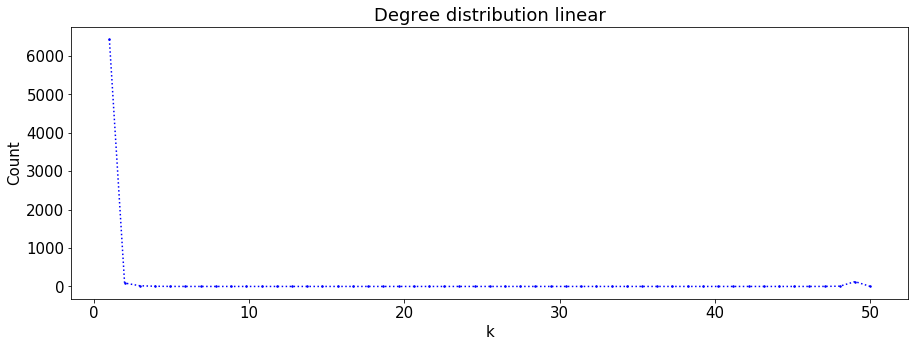

In [51]:
# Printing the maximum and minimum degree and plotting the degree distribution
plotDegree(gCPS, log = False, line = True)

#### Graph

In [114]:
# Computing the node's position using forcesatlas
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution = False,  # Dissuade hubs
                          linLogMode = False,  # NOT IMPLEMENTED
                          adjustSizes = False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence = 5.0,

                          # Performance
                          jitterTolerance = 0.5,  # Tolerance
                          barnesHutOptimize = False,
                          barnesHutTheta = 5,
                          multiThreaded = False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio = 50.0,
                          strongGravityMode = False,
                          gravity = 50.0,

                          # Log
                          verbose = True)

positionsCPS = forceatlas2.forceatlas2_networkx_layout(gCPS, pos = None, iterations = 2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:03<00:00,  7.26it/s]


('Repulsion forces', ' took ', '282.39', ' seconds')
('Gravitational forces', ' took ', '0.98', ' seconds')
('Attraction forces', ' took ', '2.30', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '4.45', ' seconds')


In [117]:
# Assigning color to the nodes based on their typology (customer or products)
nodesCPS = gCPS.nodes.keys()
nodeColorsCPS = ['navy' if gCPS.node[n]['isCust'] == True else 'orange' for n in nodesCPS]
dCPS = nx.degree(gCPS) 

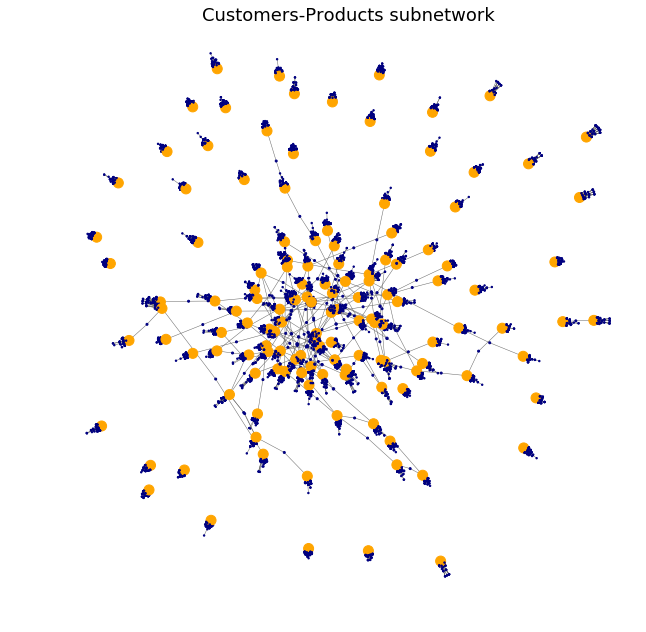

In [118]:
# Plotting the subnetwork
plt.figure(3, figsize = [8, 8])
plt.rcParams.update({'font.size': 15})
nx.drawing.nx_pylab.draw(gCPS, position = positionsCPS, nodelist = nodesCPS, cmap = plt.get_cmap('jet'), node_size = [dCPS[node]*2 for node in nodesCPS], with_labels = False, edge_color = 'dimgrey', node_color = nodeColorsCPS, width = 0.5)
plt.title('Customers-Products subnetwork')
plt.show()

#### Friendship paradox

In [193]:
# Computing the Friendship paradox
nSuccCPS = friendship(gCPS)

In [194]:
# Printing the Friendship paradox result
printFriendship("sub Customers-Products", len(gCPS), nSuccCPS)

In the sub Customers-Products network, the friendship paradox was true for 6547 times out of 6681, 97.00 per cent.


> **Outcomes:** Looking at the results, they show that the subnetwork shares the same properties of the original one. Since we considered a subset with more than 6000 nodes and edges, we expected this kind of result. Meanwhile, focussing on the graph, it can be seen that roughly half of the products are isolated. This means that many customers have reviewed only one product and only a few of them have reviewed multiple ones. 
<a id = "CPConclusion">
### Customers-Products network conclusion
> From this threefold analysis, we came out with three main points. 
* The network resembles a *Scale-free network*. This is confirmed also by the *Friendship paradox* result.
* Amazon's customers are mainly interested in entertainment categories like DVD, Music and book.
* As we could reasonably conceive, the degree distribution suggests that customers are more likely to review a few number of products, whereas, products are reviewed by a big number of users.
## Projections
> Bipartite network projection is a widely used technique to study a bipartite network. Specifically, it studies new network derived from the ogirinal one by considering only one typology of nodes. Two nodes are connected if there is path in the original network which connects them. Since this does not properly reflects all network's property, an appropriate method for weighting edges is often required. Therefore, in this section we will analyse the customers and products projections.

<a id = "Customers">

## Customers network
> **Interests:** This network represents the relationships among customers. We study this network in order to find out interesting properties across customers. Specifically, the network is created as follows:
* Nodes: Each node corresponds to a customer.
* Edges: Each edge connects two customers which have reviewed at least one product in common. In order to properly assign weights among edges, each edge has weight equal to the number of common products divided by the sum of the rates difference. By doing this, if two customers have rated the product with the same number of stars, the weight will be equal to 1. On the other hand, if they have given different rates, the weight will be lower.
> In the beginning, we will build the projection and we will perform the same [basic stast analysis](#Customer-Products) that we did before. 

> **Tool:** Since the analysis is the same of the previous one, the tools used are the same as well.

> **Application of the tool:** Since the network's size exponentially increases with the number of products considered, it was infeasible to create the projection of the whole orignal network. Consequently, we built the projection of the subnetwork. Meanwhile, number of nodes and edges, degree distribution and plot have been made as in the previous networks.
#### Building network

<a id = "Customers">

In [53]:
# Defining the new network
gCS = nx.Graph()

In [164]:
# Populating the network
for node in gCPS:
    if not gCPS.node[node]["isCust"]:
        nei = list(gCPS.neighbors(node))
        if len(nei) == 1:
            gCS.add_node(nei[0])
        else:
            for i in range(len(nei) - 1):
                for j in range(i + 1, len(nei)):
                    try:
                        gCS[nei[i]][nei[j]]["weight"] += 1 / (1 + abs(gCP[nei[i]][node]["weight"] - gCP[nei[j]][node]["weight"]))
                    except KeyError as e:
                        gCS.add_node(nei[i])
                        gCS.add_node(nei[j])
                        gCS.add_edge(nei[i], nei[j], weight = 1 / (1 + abs(gCP[nei[i]][node]["weight"] - gCP[nei[j]][node]["weight"])))

In [165]:
# Writing the pickle file storing the network
nx.write_gpickle(gCS, "%scustomersSubNetwork.gpickle" %PATH_DATA)

In [60]:
# Loading the network by reading the related pickle file
gCS = nx.read_gpickle("%scustomersSubNetwork.gpickle" %PATH_DATA)

#### Number of nodes and edges

In [167]:
# Printing the number of nodes and edges
printNodesEdges(gCS)

The number of nodes is: 6547
The number of edges is: 163697


#### Degree distribution

Maximum degree = 243
Minimum degree = 47


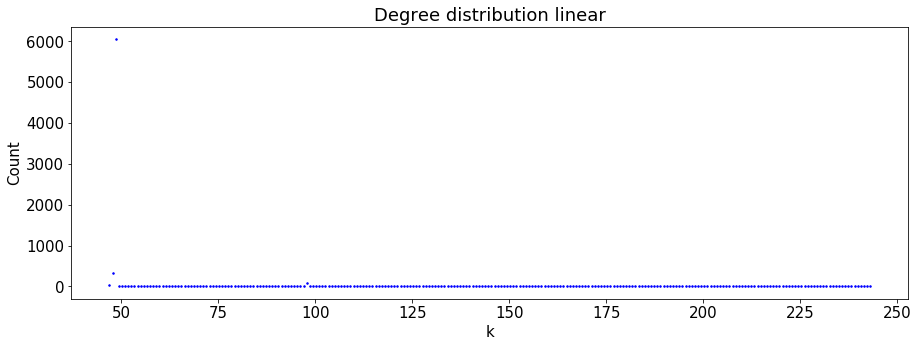

In [179]:
# Degree distribution with plot
plotDegree(gCS, log = False)

#### Graph

In [62]:
# Computing node's positions
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution = False,  # Dissuade hubs
                          linLogMode = False,  # NOT IMPLEMENTED
                          adjustSizes = False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence = 5.0,

                          # Performance
                          jitterTolerance = 0.5,  # Tolerance
                          barnesHutOptimize = False,
                          barnesHutTheta = 5,
                          multiThreaded = False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio = 50.0,
                          strongGravityMode = False,
                          gravity = 50.0,

                          # Log
                          verbose = True)
positionsCS = forceatlas2.forceatlas2_networkx_layout(gCS, pos = None, iterations = 2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:20<00:00,  6.58it/s]


('Repulsion forces', ' took ', '290.93', ' seconds')
('Gravitational forces', ' took ', '1.17', ' seconds')
('Attraction forces', ' took ', '9.49', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '5.53', ' seconds')


In [64]:
# Creating node and degree list
nodesCS = gCS.nodes.keys()
dCS = nx.degree(gCS) 

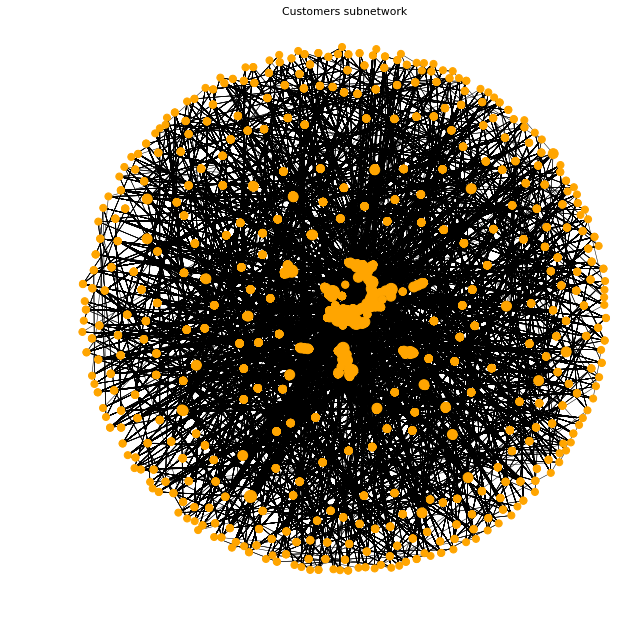

In [68]:
# Plotting the network
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gCS, positionsCS, nodelist = nodesCS, cmap = plt.get_cmap('jet'), node_size = [dCS[node]*1 for node in nodesCS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Customers subnetwork')
plt.show()

<a id = "CustomerDegree">

> **Outcomes:** Looking at the size and the degree distribution, we can observe that there is a large number of edges. This is due to the fact that the original bipartite network is composed of products with 50 reviews. As a matter of fact, the majority of the nodes has degree equal to 49 while the remaining degrees are spread among few customers. This enforces the [conclusion](#CPConclusion) of the previous network. Indeed, many customers have degree equal to 49 because they have reviewed only one product.
### Connectivity analysis
> **Interests:** In this section, we are interested in finding the centrality properties of the network. To do an accurate study, we will perform four different centrality analysis: degree centrality, closeness centrality, betweenness centrality and eigenvector centralities. By doing this, we want to understand if there are customers more connected than others, as well as if there are some interesting relationship between the most connected and the isolated ones.

> **Tool:** To perform this analysis, we use the *NetworkX*'s functions related to the desired centrality measures. In fact, *NetworkX* provides several functions which can be applied to a graph and they return a dictionary containing for each node the associated measure. For instance, to compute the closeness centrality there is the *NetworkX.closeness_centrality* function. The aforementioned centrality measures are described below.
* Degree centrality: This represents the basic way to measure the centrality. Indeed, it is based only on the degree. A centrality of a node increases within its degree.
* Closeness centrality: This centrality is given by the mean distance from a node to the other ones. Therefore, the more a node is central, the higher is its closeness centrality.
* Betweenness centrality: This measure is based on the shortest path. It is the number of time a node is between the shortest path of other two nodes. It gives information regarding how much a node connects other nodes.
* Eigenvector centrality: This represents the influence of a node in the network. Centralities are assigned based on the concept that connections to high-scoring nodes contribute more than the connections to low-scoring nodes. High eigenvector centrality means that the node is connected to other nodes with high centrality as well.

> **Application of the tool:** To evaluate these measures, we first compute the considered measure through the related *NetworkX*'s function. Secondly, we plot the network setting the node's size based on its degree/closeness/betweenness/eigenvector centrality. Lastly, we plot the associated distribution.

#### Closeness centrality

In [61]:
# Computing closeness centrality
ccCS = nx.closeness_centrality(gCS)

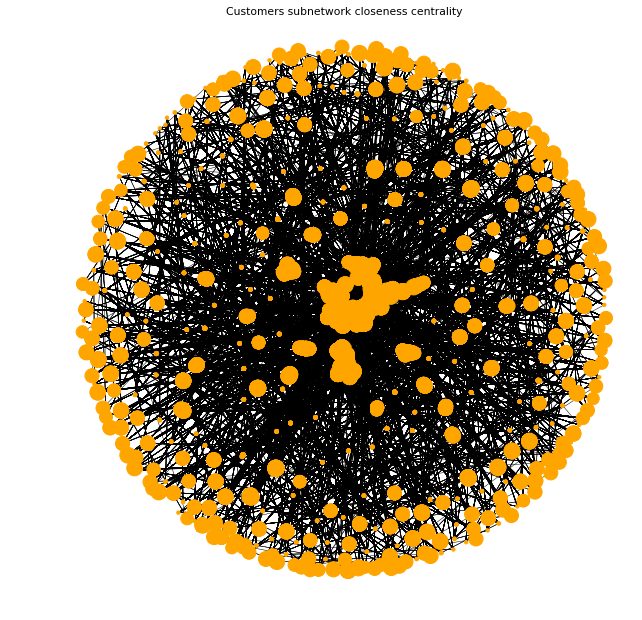

In [81]:
# Plotting network based on the closeness connectivity
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gCS, positionsCS, nodelist = nodesCS, cmap = plt.get_cmap('jet'), node_size = [ccCS[node]*1500 for node in nodesCS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Customers subnetwork closeness centrality')
plt.show()

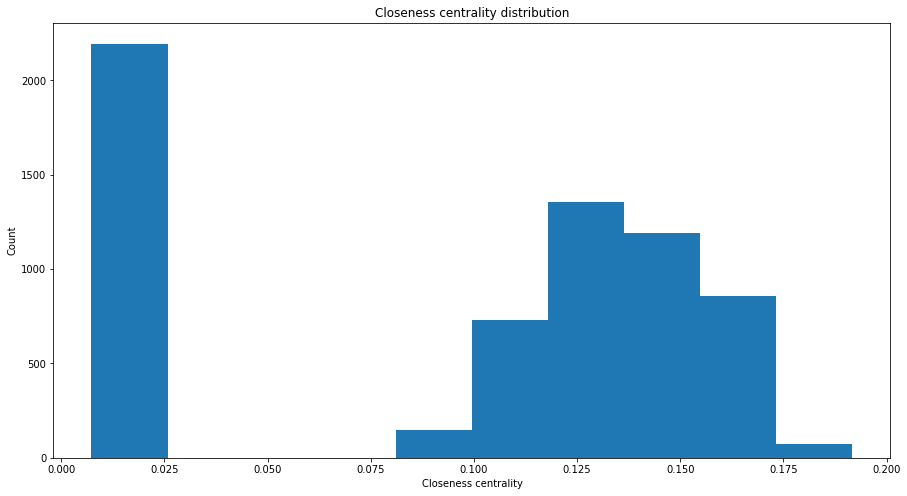

In [62]:
# Plotting the closeness centrality distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.hist(list(ccCS.values()), 10)
plt.title('Closeness centrality distribution')
plt.xlabel('Closeness centrality')
plt.ylabel('Count')
plt.show()

#### Betweenness connectivity

In [69]:
# Computing betweenness centrality
bcCS = nx.betweenness_centrality(gCS)

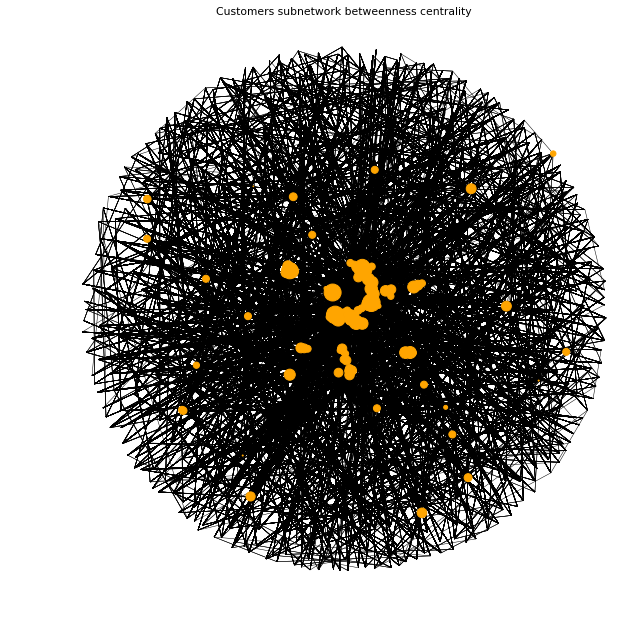

In [70]:
# Plotting networking based on the betweenness centrality
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gCS, positionsCS, nodelist = nodesCS, cmap = plt.get_cmap('jet'), node_size = [bcCS[node]*5000 for node in nodesCS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Customers subnetwork betweenness centrality')
plt.show()

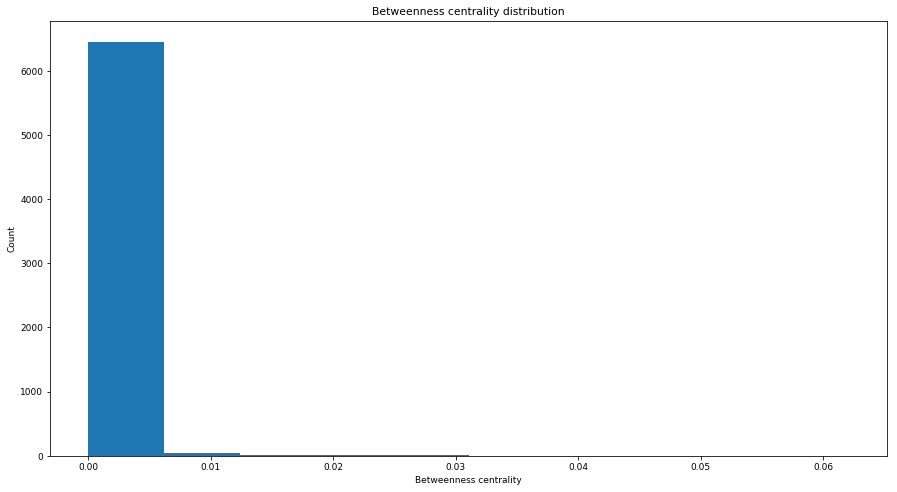

In [84]:
# Printing the betweenness cetrality distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.hist(list(bcCS.values()), 10)
plt.title('Betweenness centrality distribution')
plt.xlabel('Betweenness centrality')
plt.ylabel('Count')
plt.show()

#### Eigenvector centrality

In [82]:
# Computing eigenvector centrality
ecCS = nx.eigenvector_centrality_numpy(gCS)

C:\Users\mirko\Anaconda2\lib\site-packages\matplotlib\collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


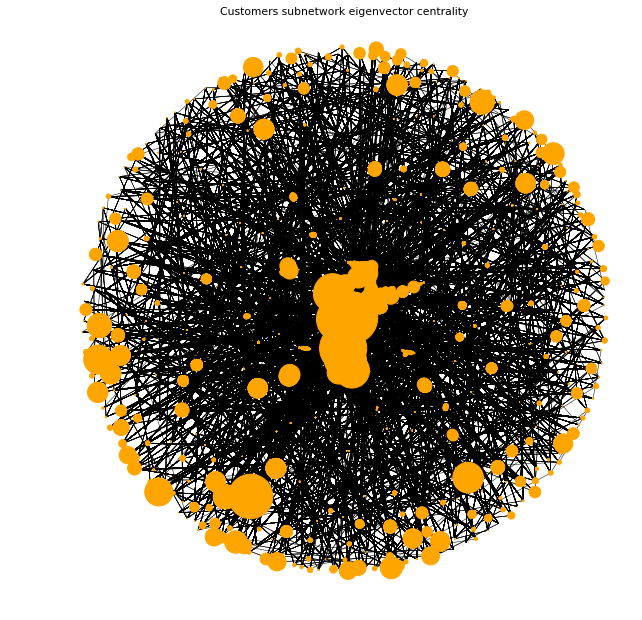

In [74]:
# Plotting network based on eigenvector centrality
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gCS, positionsCS, nodelist = nodesCS, cmap = plt.get_cmap('jet'), node_size = [ecCS[node]*15500 for node in nodesCS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Customers subnetwork eigenvector centrality')
plt.show()

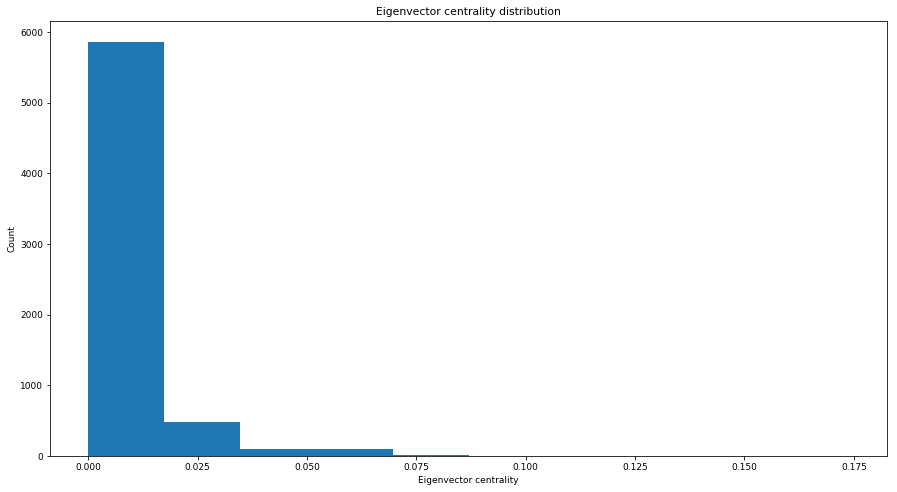

In [76]:
# Plotting the eigenvector centrality distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.hist(xecCS, 10)
plt.title('Eigenvector centrality distribution')
plt.xlabel('Eigenvector centrality')
plt.ylabel('Count')
plt.show()

<a id = "CustomerCentrality">

> **Outcomes:** 
* Degree centrality: Looking at this measure, it can be observed that there are many customers which the same degree (49). This is due to the fact that we are considering the subnetwork composed by the product with 50 reviewed. Basically, this analysis corresponds to the degree ones that we have done in the [previous section](#CustomerDegree).
* Closeness centrality: This measure seems more distributed than the previous one. The graph and the distribution suggest that there two main groups. The former is composed by nodes with a smaller closeness centrality. The latter is characterized by a higher value of closeness centrality. We suppose that the first group represents the customer with few reviews, whereas, the second one gathers the customers with more than one review.
* Betweeness centrality: Looking at the graph as well as at the distribution, it can be observed that the majority of the nodes have a tiny betweenness centrality. Only a few nodes have a remarkable value. This suggests that there are many "isolated" customers which are connected few ones.
* Eigenvector centrality: The eigenvector centrality enforces what we have seen in the previous one. In fact, nodes with a higher betweenness have an even higher eigenvector centrality. This is due to nature of the eigenvector centrality.

> On the whole, this centrality analysis revealed that there are only a few nodes which are well connected, while the other ones have just a few connections. With few connections, we mean that they have only the connection with the customers who have reviewed the same product.
### Assortativity
> **Interests:** Here, we want to study if customer nodes tend to connect to other nodes which are similar in some way.

> **Tool:** Assortativity assigns a score from -1 to 1 which indicates how much network's nodes tend to connect with other similar nodes.

> **Application of the tool:** We studied this property by applying the *NetworkX.degree_assortativity_coefficient* function which receives as input a graph and a parameter to use as weight and return the assortativity coefficient. Since in our network edge's weight are relevant, we used this function by considering the edge's weight.

<a id = "CustomerAssortativity">

In [87]:
# Computing assortativity
assortativity(gCS)

The assortativity coeffcient is: 0.206446


<a id = "CustomerCommunity">

> **Outcomes:** The assortativity coefficient is very close to zero. This suggests that the network is non-assortative. This reveals that nodes do not strictly tend to connect with nodes that have a similar degree.
### Community
> **Interests:** In this section, we will perform an analysis in order to find out communities among the customers. The main purpose is to identify if customers are correlated, therefore, we will study if the network reveals interesting properties. In case of positive result, this analysis could be used to perform a product recommendation to the customers. 

> **Tool:** A network has a community structure if its nodes can be easily grouped into communities and in each community, nodes are densely connected. Correlated to the community analysis, there is the modularity measure. This measure is applied to a community partition. It rates the quality of that partition. The higher is the modularity, the better is the partition. Therefore, it is used to validate the communities that have been previously found.

> **Application of the tool:** To perform this analysis, we use the *Community* package which provides several useful functions to compute a community analysis. We will detect communities through the *Community.best_partition* function which receives as input a graph and returns a dictionary containing the found communities. This function apllies the Louvain algorithm. Similarly, we use the *Community.modularity* function to evaluate the quality of the partition found. Then, we plot the network assigning a different colour to each community. Thus, each node will have the colour of the associated community. Lastly, we find the number of communities found by the algorithm and we print the top/bottom 10 communities (the ones with a higher/lower number of nodes).

In [12]:
# Computing community detection
comCS = community.best_partition(gCS)

In [13]:
# Computing modularity measure
print("The modularity with python Louvain-algorithm implementation is %f" %(community.modularity(comCS, gCS)))

The modularity with python Louvain-algorithm implementation is 0.979303


#### Plotting community graph

In [223]:
# In order to assign a different to color to each community found by the Louvain algorithm, we define a color array where each 
# element corresponds to a network node and the related color is found by multiplying its community id by 100000. The reason why
# we chose 100000 is to have a wider range of colors since each community color will differ to at least 100000 from all the
# other ones.
comColorsCS = ["#" + '{:06x}'.format(comCS[c] * 10000) for c in nodes]

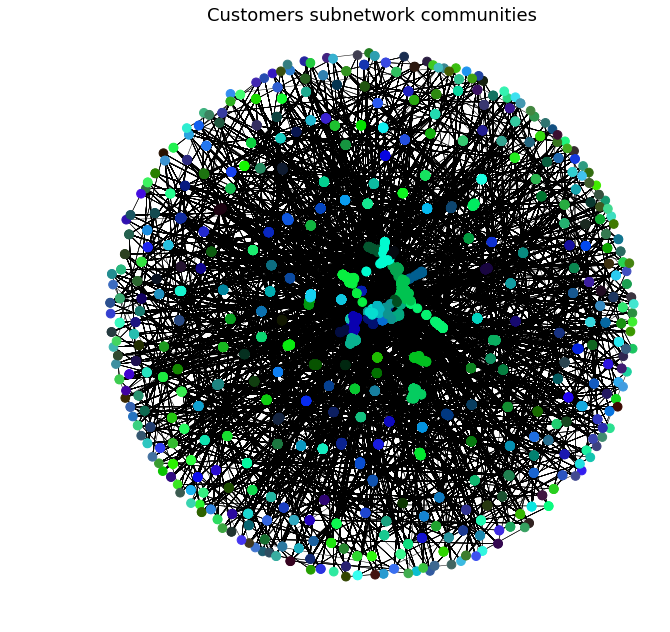

In [225]:
# Plotting network based on communities
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gCS, positionsCS, nodelist = nodesCS, cmap = plt.get_cmap('jet'), node_size = 75, with_labels = False, edge_color = 'black', node_color = comColorsCS, width = 0.5)
plt.title('Customers subnetwork communities')
plt.show()

#### Top/Bottom communities

In [14]:
# Printing the number of communities found by the alogrithm
print("Louvain algorithm found %d communities" %(max(comCS.values())))

Louvain algorithm found 450 communities


In [49]:
# Finding the communities containing the higher number of nodes
sort = dict()
for c in comCS:
    try:
        sort[comCS[c]] += 1
    except KeyError as e:
        sort[comCS[c]] = 1
topCom = sorted(sort.items(), key=lambda kv: kv[1], reverse = True)
print("The top 10 communties are:")
print(topCom[:10])
print("The bottom 10 communities are:")
print(topCom[-10:])

The top 10 communties are:
[(5, 250), (59, 170), (52, 156), (38, 149), (7, 138), (45, 134), (18, 124), (39, 124), (13, 119), (44, 111)]
The bottom 10 communities are:
[(440, 1), (441, 1), (442, 1), (444, 1), (445, 1), (446, 1), (447, 1), (448, 1), (449, 1), (450, 1)]


> **Outcomes:** 450 communities have been found by the algorithm. Additionally, the modularity is very close to 1. This suggests that the found partition is reliable and the network shows a "community" structure. The biggest community has 250 nodes and all the top 10 communities have more than 100 nodes. Meanwhile, the smaller ones are composed of isolated nodes. This suggests that customers with a higher number of reviews create communities with other customers which have reviewed the same products. On the other hand, customers which have reviewed only one product remains isolated.
### Customers network onclusion
> On the whole, this network analysis revealed that customers are more likely to review a few numbers of products. However, there are users with a significant number of reviews. This is reflected in the community properties of the network. Indeed, customers with many reviews tend to create a community with other similar users, whereas, the ones with few reviews tend to be isolated. With similar users, we mean that they have reviewed similar products. This is the most interesting point in this analysis. The community structure allows to group customers based on their product preferences. Through the communities, it is possible to realize a recommendation system. The idea is to suggest products which have been bought by customers appertaining to the same community. For this reason, it would be very interesting to enhance our study by considering more products and consequently, considering more customers. This would allow to have more information about users and create a more accurate partition and recommendation. 

<a id = "Products">

## Products network
> **Interests:** This network represents the relationships among products. We study this network in order to find out interesting properties across products. Specifically, the network is created as follows:
* Nodes: Each node corresponds to a product. Nodes are characterized by two properties:
    * Category: It is the category of the product
    * Title: It is the name of the product
* Edges: Each edge connects two products which have been reviewed by at least one customer in common. In order to properly assign weights among edges, each edge has weight equal to the number of common customers.

> During this analysis, we will perform almost the same measures that we did with the [Customers network](#Customers). The purpose is to find the same properties but in the products perspective.  

> **Tool:** Since the analysis is the same of the previous one, the tools used are the same as well.

> **Application of the tool:** Since the network's size exponentially increases with the number of products considered, the first part of the analysis will be performed considering the projection of the whole original network. Meanwhile, when it will impossible to use the enitre one, we will use the projection of the [subnetwork](#Subnetwork).
#### Building network 

In [10]:
# Defining the new network
gP = nx.Graph()

In [234]:
# Creating a dictionary containing for each customers the associated reviews. This will speed up the creation 
# of the following network
customersDict = dict()
for index, row in df_no_text.iterrows():
    try:
        customersDict[row.customer_id].append((row.product_id, index))
    except KeyError as k:
        customersDict[row.customer_id] = [(row.product_id, index)]

In [235]:
# Writing the pickle file storing the dictionary
with open('%scustomersDict.pickle'%PATH_DATA, 'wb') as handle:
    pickle.dump(customersDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Loading the dictionary from the related pickle file
with open('%scustomersDict.pickle'%PATH_DATA, 'rb') as handle:
    customersDict = pickle.load(handle)

In [14]:
# Populating the network
count = 1
for cu, pr in customersDict.items():
    if count % 50000 == 0:
        print("%d/935880" %(count))
    count += 1
    if len(pr) == 1:
        gP.add_node(pr[0][0])
    else:
        for i, (prodIdI, revIdI) in enumerate(pr[:-1]):
            for prodIdJ, revIdJ in pr[i+1:]:
                try:
                    gP[prodIdI][prodIdJ]["weight"] += 1
                except KeyError as e:
                    gP.add_node(prodIdI, title = df_no_text.loc[revIdI].product_title, cat = df_no_text.loc[revIdI].product_category)
                    gP.add_node(prodIdJ, title = df_no_text.loc[revIdJ].product_title, cat = df_no_text.loc[revIdJ].product_category)
                    gP.add_edge(prodIdI, prodIdJ, weight = 1)

50000/935880
100000/935880
150000/935880
200000/935880
250000/935880
300000/935880
350000/935880
400000/935880
450000/935880
500000/935880
550000/935880
600000/935880
650000/935880
700000/935880
750000/935880
800000/935880
850000/935880
900000/935880


In [15]:
# Writing the picke file storing the network
nx.write_gpickle(gP, "%sproductsNetwork.gpickle" %PATH_DATA)

In [74]:
# Loading the network from the related pickle file
gP = nx.read_gpickle("%sproductsNetwork.gpickle" %PATH_DATA)

In [19]:
# Printing the number of nodes and edges
printNodesEdges(gP)

The number of nodes is: 58443
The number of edges is: 5699232


#### Degree distribution 

Maximum degree = 5871
Minimum degree = 0


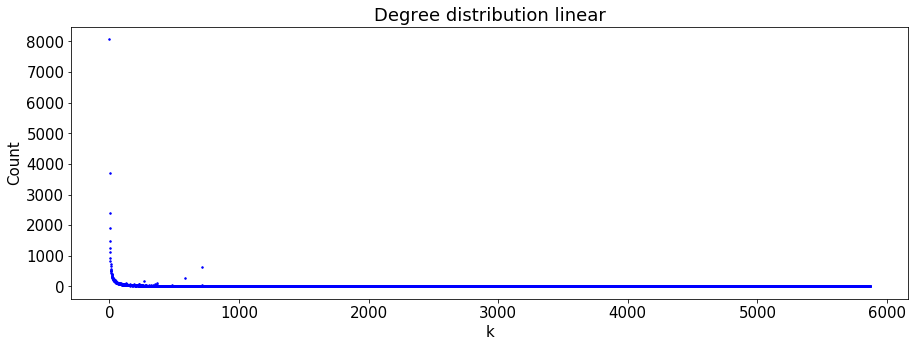

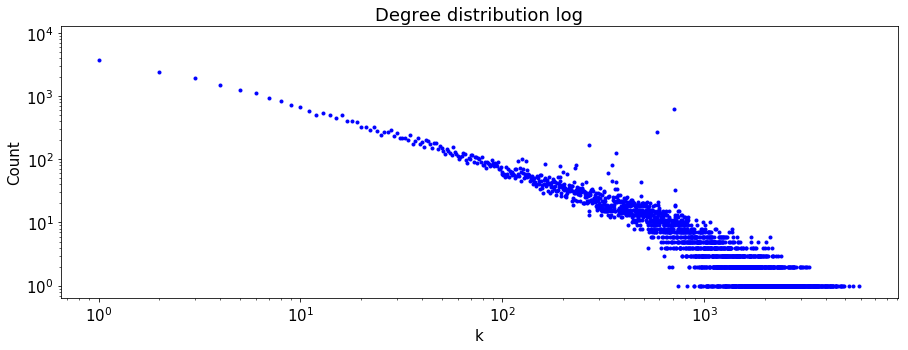

In [52]:
# Printing the maximum and minimum degree and plotting the degree distribution
plotDegree(gP)

> **Outcomes:** Looking at the results, it can be seen that the network has a huge number of edges. This means that products are well connected. Additionally, the degree distribution suggests that there is a remarkable number of products with a small degree but at the same time, other ones have a large number of connections. Probably, this is due to the fact that many products have been reviewed by a small number of customers, therefore, they are poorly connected with the other ones. On the other hand, products with many reviews are well connected, because they share more customers. We expected this kind of result, in fact, it sounds reasonable that the majority of products have few reviews and few products have been bought by a lot of users.
### Best products analysis
> **Interests:** Here, we are interested in identifying which are the best products in terms of review number, as well as which are the best categories. By doing this, we want to understand if there is a clear distinction between or they more products/categories with a similar number of reviews. 

> **Tool:** To perform this analysis, we will use *Matplotlib* to plot the category and products distribution based on the number of reviews. 

> **Application of the tool:** To identify the best categories, we first create a dictionary containing for each category the number of reviews. Secondly, we plot them sorted by the number of reviews. Successively, we repeat the same procedure for the product analysis. 
#### Category distribution

In [21]:
# Creating dictionary containing the category's number of reviews
cat = dict()
for node in gP.nodes():
    try:
        cat[gP.node[node]["cat"]] = cat.get(gP.node[node]["cat"], 0) + gP.degree(node)
    except KeyError as e:
        continue
impc = sorted(cat.items(), key=lambda kv: kv[1], reverse = True)
xc, yc = [], []
for c in impc:
    xc.append(c[0])
    yc.append(c[1])

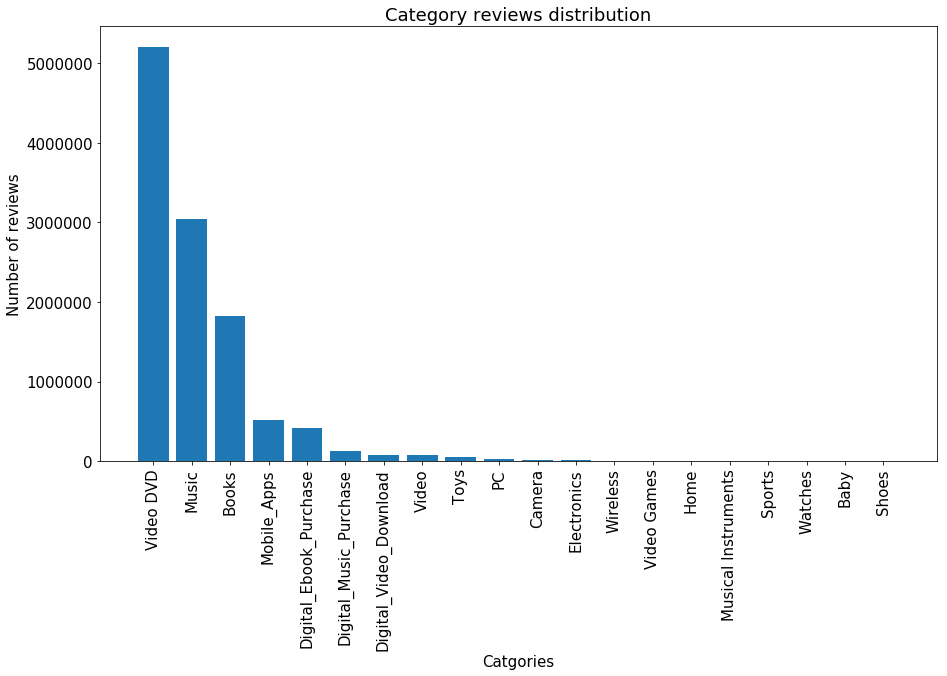

In [22]:
# Plotting the category reviews distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.bar(xc, yc)
plt.xticks(xc, xc, rotation = 'vertical')
plt.title('Category reviews distribution')
plt.xlabel('Catgories')
plt.ylabel('Number of reviews')
plt.show()

> As can be seen in the plot above, many cateogries have few reviews compared with the bigger ones. Therefore, now we plot again by considering only the important ones.

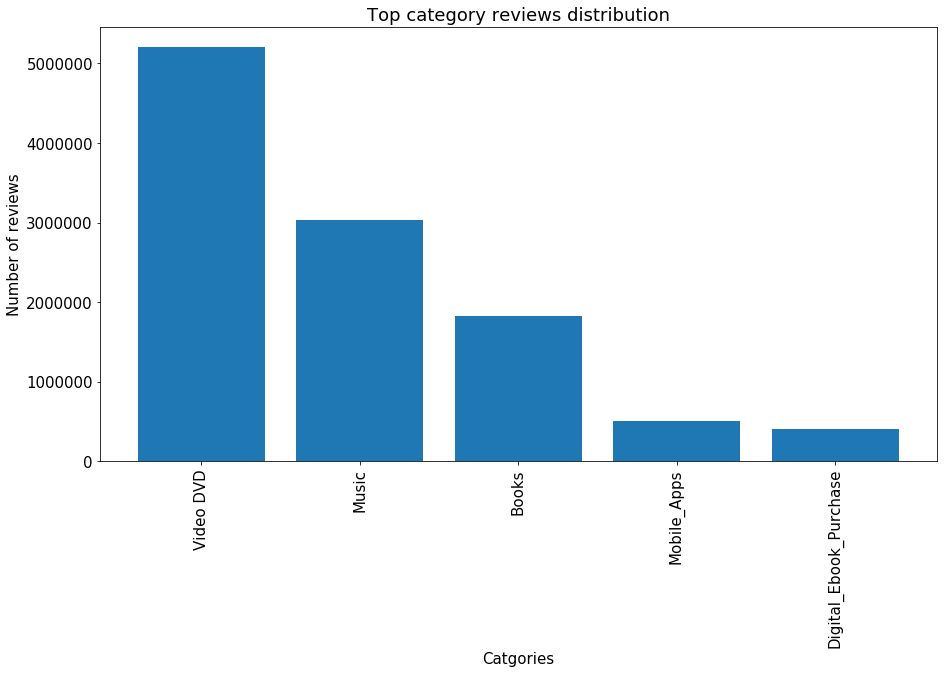

In [24]:
# Plotting the top 5 categories
plt.rcParams["figure.figsize"] = [15, 8]
plt.bar(xc[:5], yc[:5])
plt.xticks(xc[:5], xc[:5], rotation = 'vertical')
plt.title('Top category reviews distribution')
plt.xlabel('Catgories')
plt.ylabel('Number of reviews')
plt.show()

#### Product distribution

In [25]:
# Creating dictionary containing the product's number of reviews
pro = dict()
for node in gP.nodes():
    try:
        pro[gP.node[node]["title"]] = gP.degree(node)
    except KeyError as e:
        continue
impp = sorted(pro.items(), key=lambda kv: kv[1], reverse = True)
xp, yp = [], []
for p in impp:
    xp.append(p[0])
    yp.append(p[1])

> Due to the huge number of different products, we plot only the top 50.

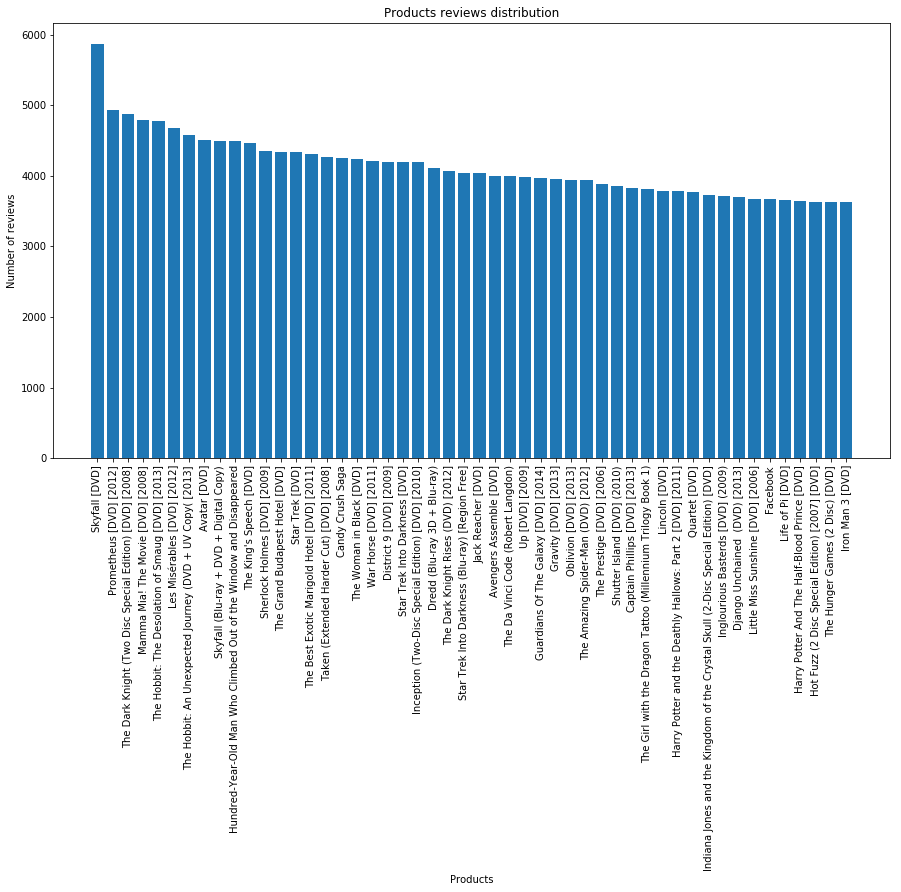

In [29]:
# Plotting the top 50 products distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.bar(xp[:50], yp[:50])
plt.title('Products reviews distribution')
plt.rcParams.update({'font.size': 8})
plt.xticks(xp[:50], xp[:50], rotation = 'vertical')
plt.xlabel('Products')
plt.ylabel('Number of reviews')
plt.show()

> **Outcomes:** The result of this analysis reflects what we already found in the [category analysis](#PreTopCategory). Indeed, the top categories are the entertainment ones. Even though we already knew the top categories, this analysis revealed that there is a remarkable difference between them. This means the top category, Video DVD, has significantly more reviews than the second one, Music. The same is recursively respected among the other ones. Looking at the product's result, it confirms what category analysis suggested. In fact, almost all of the top 50 products correspond to DVD. An interesting point is that only two very famous mobile apps like Candy Crush Saga and Facebook, appear in the top 50. On the whole, we understood that customers are really in love with movies and DVD.
### Subnetwork analysis
> **Interests:** Due to the large size of the network, we were not able to proceed the analysis using the projection based on the whole network. It requires an infeasible amount of time. Consequently, we decided to build the projection related to the [subnetwork](#Subnetwork). Throught this subnetwork's projection, we will study the centrality, assorativity and community property of the network.

> **Tool:** As the first thing, we create the network and then, we study its size and degree distribution. Therefore, we use the same tool that we used at the [beginning](#Customers-Products). 

> **Application of the tool:** This procedure is similar to the one used in the [customers network](#Customers).
#### Building network

In [36]:
# Defininf the new network
gPS = nx.Graph()

In [39]:
# Populating the network
for node in gCPS:
    if gCPS.node[node]["isCust"]:
        nei = list(gCPS.neighbors(node))
        if len(nei) == 1:
            gPS.add_node(nei[0], title = gCPS.node[nei[0]]["title"], cat = gCPS.node[nei[0]]["cat"])
        else:
            for i in range(len(nei) - 1):
                for j in range(i + 1, len(nei)):
                    try:
                        gPS[nei[i]][nei[j]]["weight"] += 1
                    except KeyError as e:
                        gPS.add_node(nei[i], title = gCPS.node[nei[i]]["title"], cat = gCPS.node[nei[i]]["cat"])
                        gPS.add_node(nei[j], title = gCPS.node[nei[j]]["title"], cat = gCPS.node[nei[j]]["cat"])
                        gPS.add_edge(nei[i], nei[j], weight = 1)

In [40]:
# Writing the pickle file storing the network
nx.write_gpickle(gPS, "%sproductsSubNetwork.gpickle" %PATH_DATA)

In [52]:
# Loading the network from the related pickle file
gPS = nx.read_gpickle("%sproductsSubNetwork.gpickle" %PATH_DATA)

#### Number of nodes and edges

In [11]:
# Printing the number of nodes and edges
printNodesEdges(gPS)

The number of nodes is: 134
The number of edges is: 171


#### Degree distribution

Maximum degree = 11
Minimum degree = 0


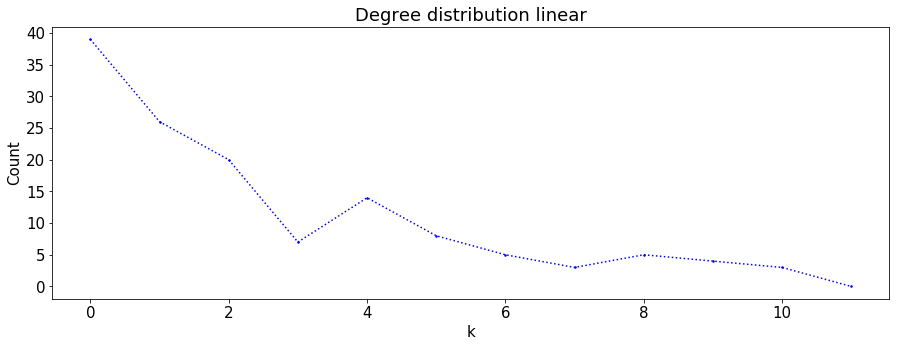

In [12]:
# Printing the maximum and minimum degree and plotting the degree distribution
plotDegree(gPS, log = False, line = True)

#### Graph

In [55]:
# Computing the node's position by means of forceatlas
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution = False,  # Dissuade hubs
                          linLogMode = False,  # NOT IMPLEMENTED
                          adjustSizes = False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence = 5.0,

                          # Performance
                          jitterTolerance = 0.5,  # Tolerance
                          barnesHutOptimize = False,
                          barnesHutTheta = 5,
                          multiThreaded = False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio = 50.0,
                          strongGravityMode = False,
                          gravity = 50.0,

                          # Log
                          verbose = True)

positionsPS = forceatlas2.forceatlas2_networkx_layout(gPS, pos = None, iterations = 2000)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4773.27it/s]


('Repulsion forces', ' took ', '0.11', ' seconds')
('Gravitational forces', ' took ', '0.04', ' seconds')
('Attraction forces', ' took ', '0.02', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.12', ' seconds')


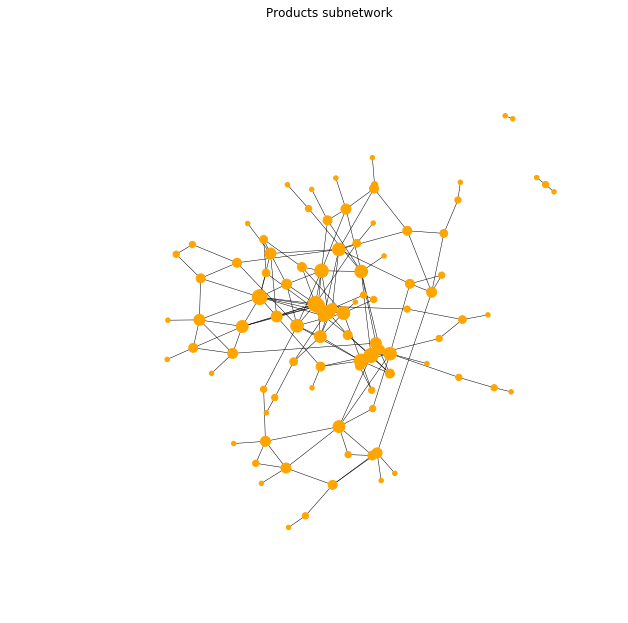

In [56]:
# Plotting the subnetwork' projection based on the node's degree.
nodesPS = gPS.nodes.keys()
dPS = nx.degree(gPS) 
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPS, positionsPS, nodelist = nodesPS, cmap = plt.get_cmap('jet'), node_size = [dPS[node]*20 for node in nodesPS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Products subnetwork')
plt.show()

<a id = "ProductDegree">

> **Outcomes:** Firstly, the projection found by the subgraph is quite small. In fact, it is composed of 134 nodes and 171 edges. The computation is fast, consequently, we could consider a bigger subnetwork. However, we preferred to keep this one in order to finish the whole network analysis in the same sample. Since this is the same used for the bipartite subnetwork analysis, as well as for the customers network, we chose to continue with this small network such that all results regard the same subgraph. By doing this, we will be able to figure out a final global analysis. That said, the degree distribution follows the usual shape. Looking at the graph, it shows that there are some hub nodes in the middle which probably represent the products with more reviews.
### Connectivity analysis
> **Interests:** In this section, we are interested in finding the centrality properties of the network. To do an accurate study, we will perform four different centrality analysis: degree centrality, closeness centrality, betweenness centrality and eigenvector centralities. By doing this, we want to understand if there are products more connected than others, as well as if there are some interesting relationship between the most connected and the isolated ones.

> **Tool:** This analysis is follows the one that we did in [Customer's connectivity analysis](#CustomerDegree). Therefore, it uses the same tools.

> **Application of the tool:** This analysis is follows the one that we did in [Customer's connectivity analysis](#CustomerDegree). Therefore, the procedure is almost the same.
#### Closeness centrality

In [57]:
# Computing closeness centrality
ccPS = nx.closeness_centrality(gPS)

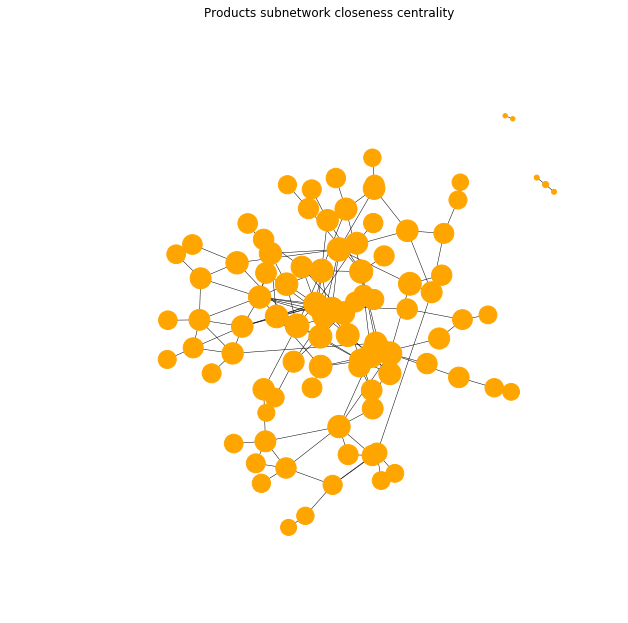

In [58]:
# Plotting network based on the closeness centrality
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPS, positionsPS, nodelist = nodesPS, cmap = plt.get_cmap('jet'), node_size = [ccPS[node]*2500 for node in nodesPS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Products subnetwork closeness centrality')
plt.show()

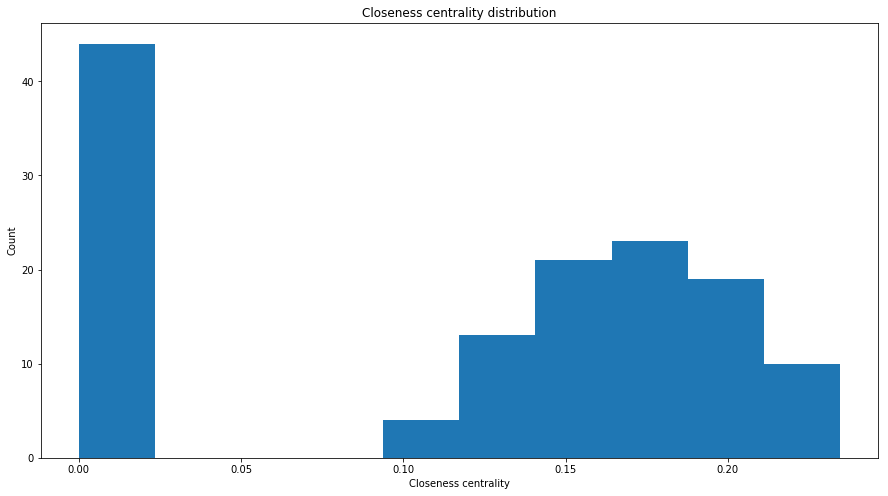

In [63]:
# Plotting the closeness centrality distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.hist(list(ccPS.values()), 10)
plt.title('Closeness centrality distribution')
plt.xlabel('Closeness centrality')
plt.ylabel('Count')
plt.show()

#### Betweenness centrality

In [64]:
# Computing betweenness centrality
bcPS = nx.betweenness_centrality(gPS)

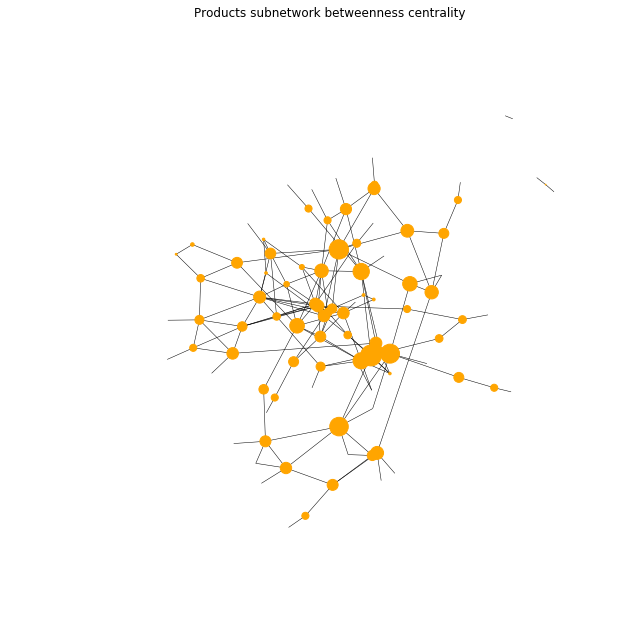

In [65]:
# Plotting network based on the betweenness centrality
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPS, positionsPS, nodelist = nodesPS, cmap = plt.get_cmap('jet'), node_size = [bcPS[node]*5000 for node in nodesPS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Products subnetwork betweenness centrality')
plt.show()

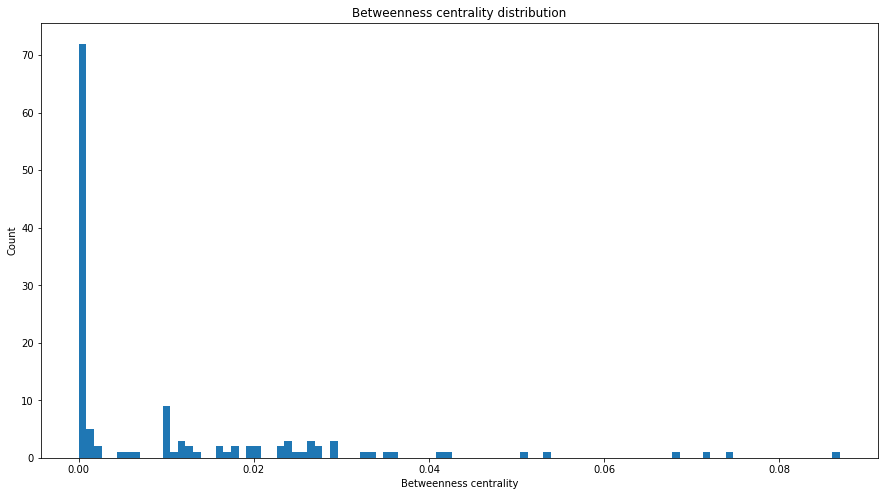

In [72]:
# Plotting the betweenness centrality distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.hist(list(bcPS.values()), 100)
plt.title('Betweenness centrality distribution')
plt.xlabel('Betweenness centrality')
plt.ylabel('Count')
plt.show()

#### Eigenvectors centrality

In [68]:
# Computing the eigenvector centrality
ecPS = nx.eigenvector_centrality(gPS)

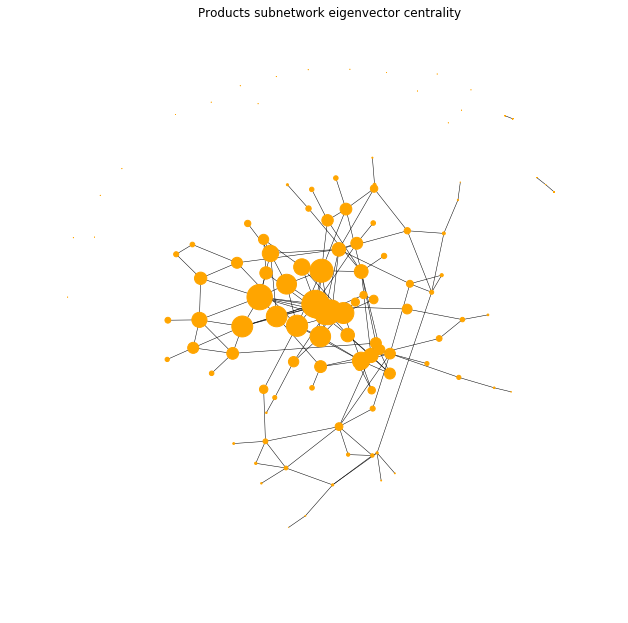

In [69]:
# Plotting the network based on the eigenvector centrality
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPS, positionsPS, nodelist = nodesPS, cmap = plt.get_cmap('jet'), node_size = [ecPS[node]*2000 for node in nodesPS], with_labels = False, edge_color = 'black', node_color = "orange", width = 0.5)
plt.title('Products subnetwork eigenvector centrality')
plt.show()

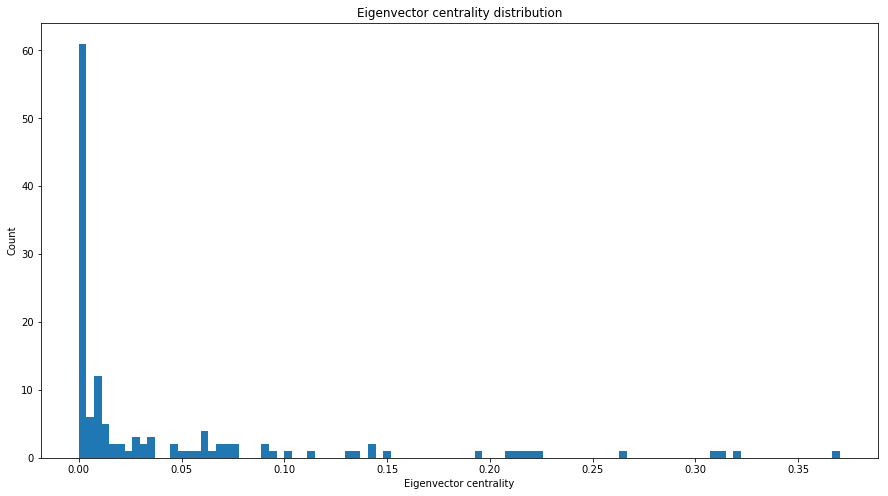

In [73]:
# Plotting the eigenvector centrality distribution
plt.rcParams["figure.figsize"] = [15, 8]
plt.hist(list(ecPS.values()), 100)
plt.title('Eigenvector centrality distribution')
plt.xlabel('Eigenvector centrality')
plt.ylabel('Count')
plt.show()

> **Outcomes:** 
* Degree centrality: This measure reflects what we have already seen [before](#ProductDegree). In summary, it can be seen that there are more products which are poorly connected because they have been reviewed by customers which have reviewed only that product. Meanwhile, the products with higher degree correspond to the ones which have been reviewed by more active customers. With active we mean that they have reviewed more than one product. 
* Closeness centrality: This measure seems very similar to the [customer network's one](#CustomerCentrality). The graph and the distribution suggest that there two main groups. The former is composed by nodes with a smaller closeness centrality. The latter is characterized by a higher value of closeness centrality. As in the [customer network](#CustomerCentrality), we suppose that the first group represents the products with reviews made by inactive customers, whereas, the second one gathers the products reviewed by the active ones.
* Betweeness centrality: The graph and the distribution confirmed what we saw in the degree and closeness centralities. Indeed, the nodes with higher centralities have a higher betweenness. This is due to the fact that since they are more connected, they are more likely to work as a bridge between the shortest path of the other two nodes.
* Eigenvector centrality: The eigenvector centrality enforces what we have seen in the previous one. It can be seen that the bigger nodes become even bigger, whereas, the smaller ones become even smaller. This is due to the eigenvector centrality's property.

> On the whole, this centrality analysis showed that the product's centrality does not depends only on the number of reviews. Since in this subnetwork all products have the same number of reviews, the difference is made by the "activeness" of the customers. Considering a product's node, it means that the more its customers are active in reviewing other products, the more it will be connected.
### Assortativity
> **Interests:** In this section, we will study if product nodes tend to connect to other nodes which are similar in some way.

> **Tool:** Assortativity assigns a score from -1 to 1 which indicates how much network's nodes tend to connect with other similar nodes.

> **Application of the tool:** The procedure is the same used in the [customer network assortativity](#CustomerAssortativity)

In [26]:
# Computing assortativity
assortativity(gPS)

The assortativity coeffcient is: 0.276852


> **Outcomes:** The assortativity coefficient is close to zero. This suggests that the network can be considered non-assortative. This reveals that nodes do not strictly tend to connect with nodes that have a similar degree.
### Community
> **Interests:** In this section, we will perform an analysis in order to find out communities among the products. The main goal is to find out if products are correlated, hence, we will analyse if the network reveals relevant properties. An interesting point is that in case of a positive result, it will be possible to perform a product recommendation of the products. Additionally, we will compare the communities found by the Louvain algorithm with ones formed by the real categories. 

> **Tool:** In addition to the tools used in the [Customer network](#CustomerCommunity) analysis, we will use a confusion matrix to compare the communities found by the algorithm with the ones made by using the real categories. A confusion matrix is a technique widely used in the machine learning field. It is a table where each row corresponds to instances of the predicted class, while column represents the instances of the actual class. This method is very useful to evaluate the prediction algorithm performs.

> **Application of the tool:** The application is quite similar to the [Customer network](#CustomerCommunity) one. In order to compare Louvain's communities with categories, we will print the network with node's colours based on the categories. Furthermore, we will create the confusion matrix as follow:
* Columns represent the communities found by the Louvain algorithm
* Rows represent the actual categories
* Each element of the matrix contains the number of nodes classified with the corresponding Louvain community and appertaining at the related category.

In [27]:
# Computing communities
comPS = community.best_partition(gPS)

In [28]:
# Computing and printing modularity
print("The modularity with python Louvain-algorithm implementation is %f" %(community.modularity(comPS, gPS)))

The modularity with python Louvain-algorithm implementation is 0.576577


> Here, we compare the number of communities found by the algorithm with the number of actual categories.

In [29]:
# Comparing number of real categoris with number of communities
ncatPS = 0
catsPS = list()
for node in gPS:
    if gPS.node[node]["cat"] not in catsPS:
        catsPS.append(gPS.node[node]["cat"])
        ncatPS += 1
print("Louvain algorithm has found %d communities" %(max(comPS.values())))
print("In the Products subnetwork there are %d different categories" %(ncatPS))

Louvain algorithm has found 48 communities
In the Products subnetwork there are 11 different categories


#### Plotting community graph

In [30]:
# In order to assign a different to color to each community found by the Louvain algorithm, we define a color array where each 
# element corresponds to a network node and the related color is found by multiplying its community id by 100000. The reason why
# we chose 100000 is to have a wider range of colors since each community color will differ to at least 100000 from all the
# other ones.
comColorsPSL = ["#" + '{:06x}'.format(comPS[c] * 100000) for c in nodesPS]

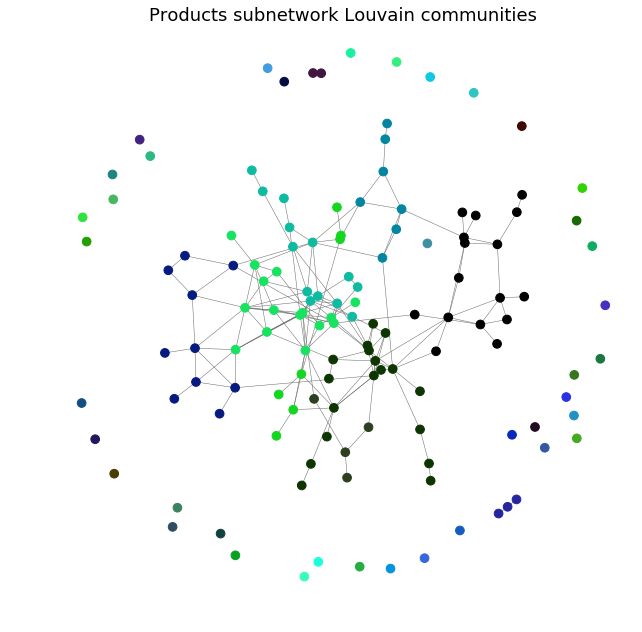

In [31]:
# Plotting network based on the Louvain communities
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPS, positionsPS, nodelist = nodesPS, cmap = plt.get_cmap('jet'), node_size = 75, with_labels = False, edge_color = 'dimgrey', node_color = comColorsPSL, width = 0.5)
plt.title('Products subnetwork Louvain communities')
plt.show()

#### Plotting categories graph

In [32]:
# Creating dictionary containing category colors
colors = dict()
c = 100000
for node in nodesPS:
    if gPS.node[node]["cat"] not in colors:
        colors[gPS.node[node]["cat"]] = c
        c += 100000

In [33]:
# Assigning colours based on the category
comColorsPSC = ["#" + '{:06x}'.format(colors[gPS.node[c]["cat"]]) for c in nodesPS]

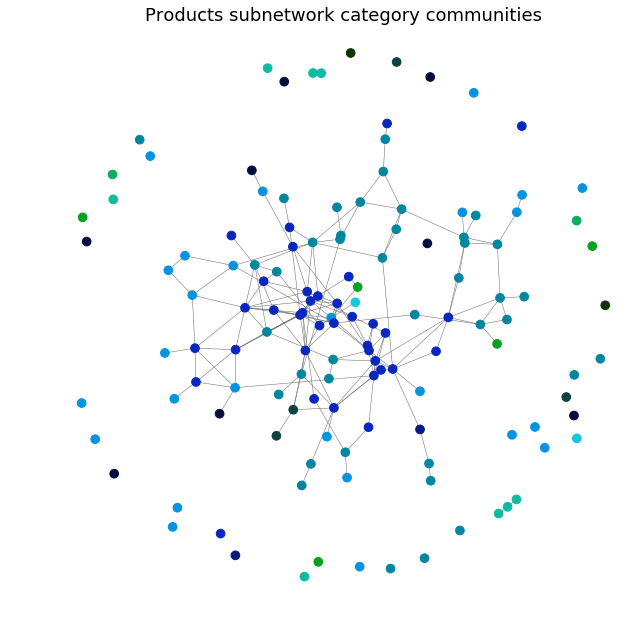

In [34]:
# Plotting the network based on the categories
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPS, positionsPS, nodelist = nodesPS, cmap = plt.get_cmap('jet'), node_size = 75, with_labels = False, edge_color = 'dimgrey', node_color = comColorsPSC, width = 0.5)
plt.title('Products subnetwork category communities')
plt.show()

#### Confusion matrix

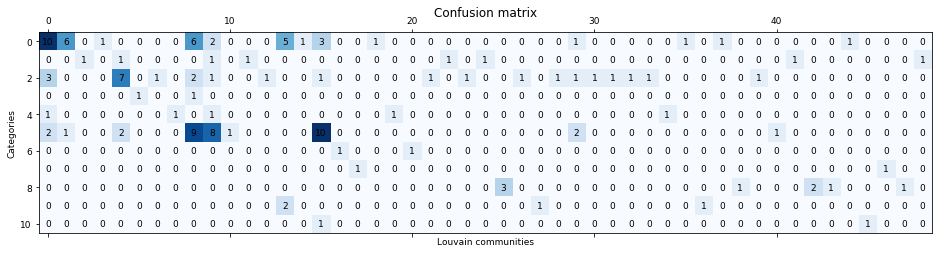

In [35]:
# Computing and plotting confusion matrix
D = [[0 for _ in range(max(comPS.values()) + 1)] for _ in range(ncatPS)]
for n in gPS:
    D[colors[gPS.node[n]["cat"]] / 100000 - 1][comPS[n]] += 1
font = {'size'   : 9}
plt.rc('font', **font)
matrix = np.matrix(D)
plt.matshow(matrix, cmap = plt.cm.Blues)
for i in xrange(max(comPS.values()) + 1):
    for j in xrange(ncatPS):
        c = matrix[j, i]
        plt.text(i, j, str(c), va = 'center', ha = 'center')
plt.title('Confusion matrix', fontsize = 12)
plt.xlabel("Louvain communities")
plt.ylabel('Categories')
plt.show()

> **Outcomes:** Firstly, the modularity is roughly 0.6. This means that there is a good community structure in the network but lower than the customer's one. This result was not really expected. Since products are gathered in categories, we supposed that they would have had a clearer community structure than customers. Secondly, it can be seen that the algorithm has found many more communities than the real number of categories. This is due to the isolated nodes, which are usually considered as a distinct community. Focussing on the connected nodes, it can be seen that the communities found by the algorithm partially correspond to the actual categories. The main difference is that the Louvain algorithm tends to group nodes in a clearer way, whereas, looking at the real categories, nodes are more mixed. On the whole, this analysis shows that there is a community structure in the network. Additionally, albeit there are some nodes which tend to connect with nodes of other categories, it confirms that nodes of the same category tend to be more connected with other nodes of the same category. Furthermore, we believe that considering a bigger subnetwork, the results would be even more accurate. 
#### Connected componet community
> **Interests:** Since the previous analysis was biased by many isolated nodes, we decided to repeat exactly the same procedure by considering the connected component of the subgraph. In this way there are no isolated nodes. The interisting point is to see if wihtout isolated nods the Louvain algortihm will better detect the communities.

> **Tool:** Reasonably, the tools are the same of the previous section.

> **Application of the tool:** As for the tools, the procedure will be the same of the previous section as well.

In [36]:
# Building connected component 
gPCC = nx.Graph(list(nx.connected_component_subgraphs(gPS, copy = True))[0])

In [37]:
# Writing pickle file storing the connected component
nx.write_gpickle(gPCC, "%sproductsCCNetwork.gpickle" %PATH_DATA)

In [77]:
# Loading connected component from the related pickle file
gPCC = nx.read_gpickle("%sproductsCCNetwork.gpickle" %PATH_DATA)

#### Connected component communities

In [39]:
# Computing connected component communities
comPCC = community.best_partition(gPCC)

In [40]:
# Writing pickle file storing connected component communities
with open('%scommunityGPCC.pickle'%PATH_DATA, 'wb') as handle:
    pickle.dump(comPCC, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
# loading connected component communities from the related pickle file
with open('%scommunityGPCC.pickle'%PATH_DATA, 'rb') as f:
    comPCC = pickle.load(f)

In [42]:
# Computing connected component modularity
print("The modularity with python Louvain-algorithm implementation is %f" %(community.modularity(comPCC, gPCC)))

The modularity with python Louvain-algorithm implementation is 0.566759


In [43]:
# Comparing the number of communities found by the Louvain algorithm with the number of different categories.
ncatPCC = 0
catsPCC = list()
for node in gPCC:
    if gPCC.node[node]["cat"] not in catsPCC:
        catsPCC.append(gPCC.node[node]["cat"])
        ncatPCC += 1
print("Louvain algorithm has found %d communities" %(max(comPCC.values())))
print("In the Products subnetwork there are %d different categories" %(ncatPCC))

Louvain algorithm has found 7 communities
In the Products subnetwork there are 8 different categories


In [44]:
# In order to assign a different to color to each community found by the Louvain algorithm, we define a color array where each 
# element corresponds to a network node and the related color is found by multiplying its community id by 100000. The reason why
# we chose 100000 is to have a wider range of colors since each community color will differ to at least 100000 from all the
# other ones.
nodesPCC = gPCC.nodes()
comColorsPCCL = ["#" + '{:06x}'.format(comPCC[c] * 100000) for c in nodesPCC]

In [45]:
# Computind node's position of the connected component
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution = False,  # Dissuade hubs
                          linLogMode = False,  # NOT IMPLEMENTED
                          adjustSizes = False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence = 5.0,

                          # Performance
                          jitterTolerance = 0.5,  # Tolerance
                          barnesHutOptimize = False,
                          barnesHutTheta = 5,
                          multiThreaded = False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio = 50.0,
                          strongGravityMode = False,
                          gravity = 50.0,

                          # Log
                          verbose = True)

positionsPCC = forceatlas2.forceatlas2_networkx_layout(gPCC, pos = None, iterations = 2000)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 7518.80it/s]


('Repulsion forces', ' took ', '0.08', ' seconds')
('Gravitational forces', ' took ', '0.02', ' seconds')
('Attraction forces', ' took ', '0.02', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.07', ' seconds')


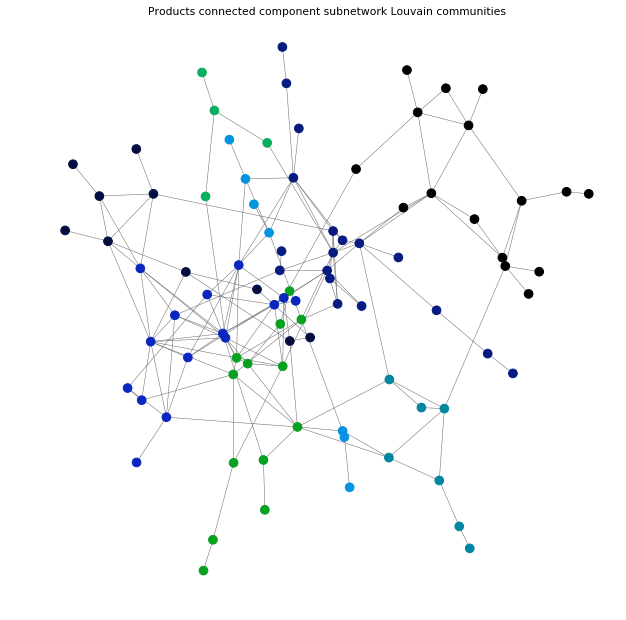

In [47]:
# Plotting connected component based on the louvain communities
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPCC, positionsPCC, nodelist = nodesPCC, cmap = plt.get_cmap('jet'), node_size = 75, with_labels = False, edge_color = 'dimgrey', node_color = comColorsPCCL, width = 0.5)
plt.title('Products connected component subnetwork Louvain communities')
plt.show()

Now plot the network based on the categories

In [48]:
# Creating dictionary containing category colors
colors = dict()
c = 100000
for node in nodesPCC:
    if gPCC.node[node]["cat"] not in colors:
        colors[gPCC.node[node]["cat"]] = c
        c += 100000

In [49]:
# Assigning colour based on the node's category
comColorsPCCC = ["#" + '{:06x}'.format(colors[gPCC.node[c]["cat"]]) for c in nodesPCC]

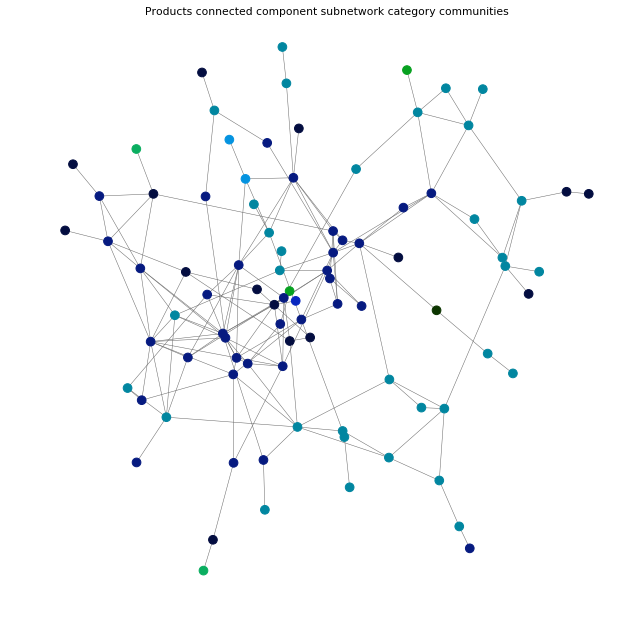

In [60]:
# Plotting connected component based on the categories
plt.figure(3, figsize = [8, 8])
nx.drawing.nx_pylab.draw(gPCC, positionsPCC, nodelist = nodesPCC, cmap = plt.get_cmap('jet'), node_size = 75, with_labels = False, edge_color = 'dimgrey', node_color = comColorsPCCC, width = 0.5)
plt.title('Products connected component subnetwork category communities')
plt.show()

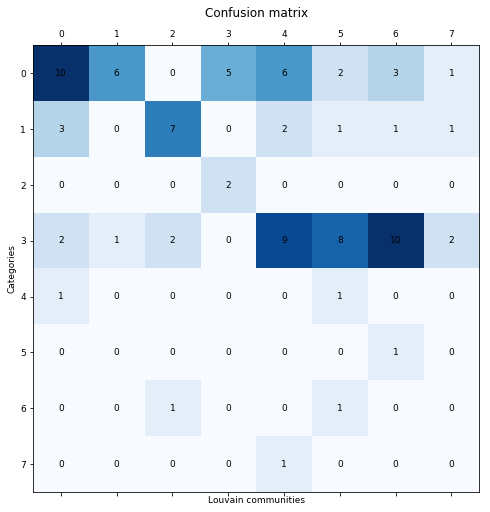

In [52]:
# Computoing connected component confusion matrix
DCC = [[0 for _ in range(max(comPCC.values()) + 1)] for _ in range(ncatPCC)]
for n in gPCC:
    DCC[colors[gPCC.node[n]["cat"]] / 100000 - 1][comPCC[n]] += 1
font = {'size'   : 9}
plt.rc('font', **font)
matrixCC = np.matrix(DCC)
plt.matshow(matrixCC, cmap = plt.cm.Blues)
for i in xrange(max(comPCC.values()) + 1):
    for j in xrange(ncatPCC):
        c = matrixCC[j, i]
        plt.text(i, j, str(c), va = 'center', ha = 'center')
plt.title('Confusion matrix', fontsize = 12)
plt.xlabel("Louvain communities")
plt.ylabel('Categories')
plt.show()

> **Outcomes:** The results are almost the same as the ones found by considering the whole subnetwork. The modularity is just 0.01 lower than the previous one, therefore, similar conclusions can be deduced. The same happens for the graph, indeed, the Louvain communities are neater than the category ones. The main difference is the number of communities, this time the algorithm found 7 communities which is approximately the same number of different categories. Unfortunately, removing the isolated nodes was not enough to improve the community detection. This will be an interesting point for future improvements.  
### Products network conclusion
> On the whole, this network analysis first revealed that the best categories are related to entertainment content. Video DVD is the category with more reviews. As a consequence, approximately all the best products are DVDs. The degree distribution resembles the customer's one. This is reasonable because the connection between products depends on the customers and vice versa. The subnetwork analysis showed that the centrality of a node does not depend only by its degree. Indeed, it strictly depends on the customers as well. For this reason, there are products very well connected and at the same time, there are many other poorly connected. This suggests that the former group is composed of more general products. With general products, we mean that they are reviewed from a general type of users. Therefore, their customers are more likely to review other products. Meanwhile, the latter group is composed of more specific items. This means that their customers tend to buy only that kind of product, therefore, they are less likely to review other products. For instance, a t-shirt is very likely to be bought by every kind of customers, whereas, a voltmeter will be reasonably bought only by a specific type of users. Turning to the community analysis, it showed that there is community trend among the products which approximately follows the categories. Unfortunately, the huge size of the network did not allow us to perform a clique analysis. The whole network requires too much time to be computed, while the subnetwork is too small to get relevant information. This is an interesting point for the future, additional details are explained in the [conlusine chsdvsu](#bayfydufgyd) section. 